In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
from collections import Counter
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',''])
from nltk.stem import WordNetLemmatizer

In [ ]:
res_data = pd.read_csv('zomato.csv', encoding='latin-1')
countryCode_toName = {
    1: "India",
    14: "Australia",
    30: "Brazil",
    37: "Canada",
    94: "Indonesia",
    148: "New Zealand",
    162: "Phillipines",
    166: "Qatar",
    184: "Singapore",
    189: "South Africa",
    191: "Sri Lanka",
    208: "Turkey",
    214: "UAE",
    215: "United Kingdom",
    216: "United States",
}
res_data['Country'] = res_data['Country Code'].apply(lambda x: countryCode_toName[x])

In [ ]:
res_data = res_data.loc[(res_data['Country Code'] == 1) & (res_data['City'] == 'Pune'), :]
res_data = res_data.loc[res_data['Longitude'] != 0, :]
res_data = res_data.loc[res_data['Latitude'] != 0, :]
res_data = res_data.loc[res_data['Latitude'] < 29] # clearing out invalid outlier
res_data = res_data.loc[res_data['Rating text'] != 'Not rated']
res_data['Cuisines'] = res_data['Cuisines'].astype(str)
res_data['fusion_num'] = res_data['Cuisines'].apply(lambda x: len(x.split(',')))
res_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 9154 to 9173
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         20 non-null     int64  
 1   Restaurant Name       20 non-null     object 
 2   Country Code          20 non-null     int64  
 3   City                  20 non-null     object 
 4   Address               20 non-null     object 
 5   Locality              20 non-null     object 
 6   Locality Verbose      20 non-null     object 
 7   Longitude             20 non-null     float64
 8   Latitude              20 non-null     float64
 9   Cuisines              20 non-null     object 
 10  Average Cost for two  20 non-null     int64  
 11  Currency              20 non-null     object 
 12  Has Table booking     20 non-null     object 
 13  Has Online delivery   20 non-null     object 
 14  Is delivering now     20 non-null     object 
 15  Switch to order menu

Cusine Provided

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



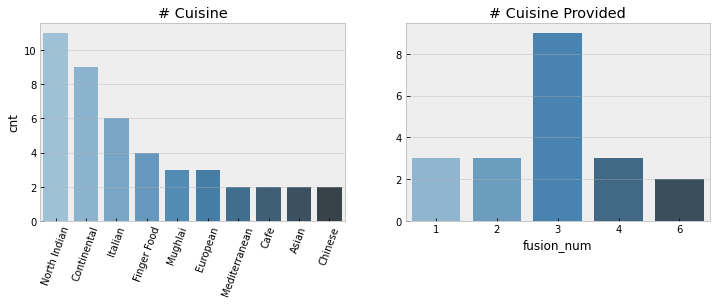

# Unique Cuisine:  23


In [ ]:
lst_cuisine = set()
Cnt_cuisine = Counter()
for cu_lst in res_data['Cuisines']:
    cu_lst = cu_lst.split(',')
    lst_cuisine.update([cu.strip() for cu in cu_lst])
    for cu in cu_lst:
        Cnt_cuisine[cu.strip()] += 1

cnt = pd.DataFrame.from_dict(Cnt_cuisine, orient = 'index')
cnt.sort_values(0, ascending = False, inplace = True)


tmp_cnt = cnt.head(10)
tmp_cnt.rename(columns = {0:'cnt'}, inplace = True)
with plt.style.context('bmh'):
    f = plt.figure(figsize = (12, 8))
    ax = plt.subplot2grid((2,2), (0,0))
    sns.barplot(x = tmp_cnt.index, y = 'cnt', data = tmp_cnt, ax = ax, palette = sns.color_palette('Blues_d', 10))
    ax.set_title('# Cuisine')
    ax.tick_params(axis='x', rotation=70)
    ax = plt.subplot2grid((2,2), (0,1))
    sns.countplot(res_data['fusion_num'], ax=ax, palette = sns.color_palette('Blues_d', res_data.fusion_num.nunique()))
    ax.set_title('# Cuisine Provided')
    ax.set_ylabel('')
    plt.show()        
print('# Unique Cuisine: ', len(lst_cuisine))

K-Means Clustering 

In [ ]:
res_data['Rating category'] = res_data['Rating text'].map({'Not rated': -1, 'Poor':0, 'Average':2, 'Good':3, 'Very Good':4, 'Excellent':5})
tmp = res_data['Aggregate rating'].map(np.round)
a = np.full(tmp.shape[0], False, dtype = bool)
((tmp - res_data['Rating category']).map(np.round)).value_counts()
sys_check = res_data[['Aggregate rating', 'Rating category', 'Votes']].copy()
sys_check['distorted'] = (res_data['Aggregate rating'] - res_data['Rating category']).map(np.round)
sys_check['diff'] = sys_check['Aggregate rating'] - sys_check['Rating category']
res_data = res_data.loc[sys_check['distorted'] != 2, :]
res_data['Rating category'] = res_data['Aggregate rating'].round(0).astype(int)

locating restaunts based on reating

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



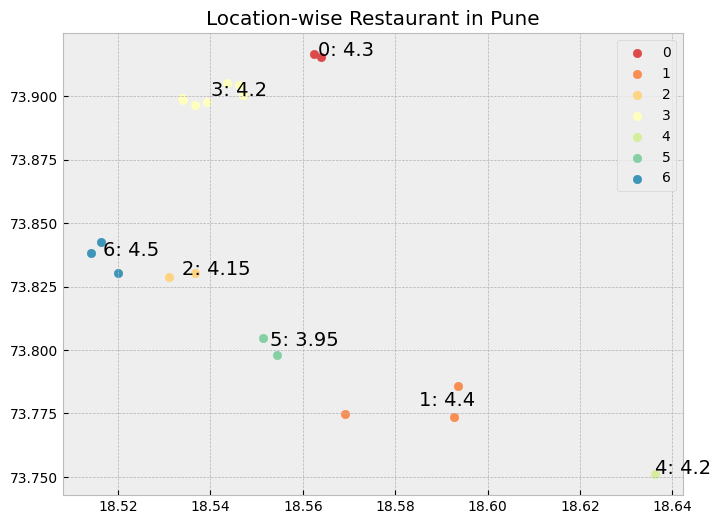

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0).fit(res_data[['Longitude', 'Latitude']])
res_data['pos'] = kmeans.labels_
pop_local = res_data.groupby('pos')['Longitude', 'Latitude', 'Aggregate rating'].agg({'Longitude':np.mean, 'Latitude':np.mean, 'Aggregate rating':np.median}).reset_index()

with plt.style.context('bmh', after_reset=True):
    pal = sns.color_palette('Spectral', 7)
    plt.figure(figsize = (8,6))
    for i in range(7):
        ix = res_data.pos == i
        plt.scatter(res_data.loc[ix, 'Latitude'], res_data.loc[ix, 'Longitude'], color = pal[i], label = str(i))
        plt.text(pop_local.loc[i, 'Latitude'], pop_local.loc[i, 'Longitude'], str(i) + ': '+str(pop_local.loc[i, 'Aggregate rating'].round(2)), fontsize = 14, color = 'black')
    plt.title('Location-wise Restaurant in Pune')
    plt.legend()
    plt.show()

Food Choice

In [ ]:
food_data = pd.read_csv('food_choices.csv')
food_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   GPA                           123 non-null    object 
 1   Gender                        125 non-null    int64  
 2   breakfast                     125 non-null    int64  
 3   calories_chicken              125 non-null    int64  
 4   calories_day                  106 non-null    float64
 5   calories_scone                124 non-null    float64
 6   coffee                        125 non-null    int64  
 7   comfort_food                  124 non-null    object 
 8   comfort_food_reasons          124 non-null    object 
 9   comfort_food_reasons_coded    106 non-null    float64
 10  cook                          122 non-null    float64
 11  comfort_food_reasons_coded.1  125 non-null    int64  
 12  cuisine                       108 non-null    float64
 13  diet_

Foode for mood

In [ ]:
food_data[['comfort_food_reasons', 'comfort_food']]

comfort_food_reasons                             comfort_food
0                            we dont have comfort                                      none
1                             Stress, bored, anger              chocolate, chips, ice cream
2                                  stress, sadness          frozen yogurt, pizza, fast food
3                                          Boredom         Pizza, Mac and cheese, ice cream
4                       Stress, boredom, cravings              Ice cream, chocolate, chips 
..                                             ...                                      ...
120                           boredom and sadness   wine. mac and cheese, pizza, ice cream 
121                Loneliness / Homesick / Sadness               Pizza / Wings / Cheesecake
122                                        sadness               rice, potato, seaweed soup
123  happiness, they are some of my favorite foods             Mac n Cheese, Lasagna, Pizza
124               hormones, Premenstrual syndrome.             Chocolates, pizza, and Ritz.

[125 rows x 2 columns]

Natural Language Processing 

In [ ]:
def search_comfort(mood):
    lemmatizer = WordNetLemmatizer()
    foodcount = {}
    for i in range(124):
        temp = [temps.strip().replace('.','').replace(',','').lower() for temps in str(food_data["comfort_food_reasons"][i]).split(' ') if temps.strip() not in stop ]
        if mood in temp:
            foodtemp = [lemmatizer.lemmatize(temps.strip().replace('.','').replace(',','').lower()) for temps in str(food_data["comfort_food"][i]).split(',') if temps.strip() not in stop ]
            for a in foodtemp:
                if a not in foodcount.keys():
                    foodcount[a] = 1 
                else:
                    foodcount[a] += 1
    sorted_food = []
    sorted_food = sorted(foodcount, key=foodcount.get, reverse=True)
    return sorted_food


def find_my_comfort_food(mood):
    topn = []
    topn = search_comfort(mood) #function create dictionary only for particular mood
    print("3 Popular Comfort Foods in %s are:"%(mood))
    print(topn[0])
    print(topn[1])
    print(topn[2])

Emotion detection Using live Face cam

In [ ]:

import numpy as np
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
from google.colab.patches import cv2_imshow
import argparse
import matplotlib.pyplot as plt
import cv2


def emotion_recog(frame):
    model.load_weights('model.h5')

    # prevents openCL usage and unnecessary logging messages
    cv2.ocl.setUseOpenCL(False)

    # dictionary which assigns each label an emotion (alphabetical order)
    emotion_dict = {0: "Angry", 1: "Disgusted", 2: "stress", 3: "Happy", 4: "laziness", 5: "Sad", 6: "Surprised"}

    # frame = cv2.imread("image1.jpg")
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 255), 3)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # cv2_imshow(frame)
    return frame


Using Face cam in Goole colab 

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

    

Saving the live image

<IPython.core.display.Javascript object>

Saved to photo.jpg


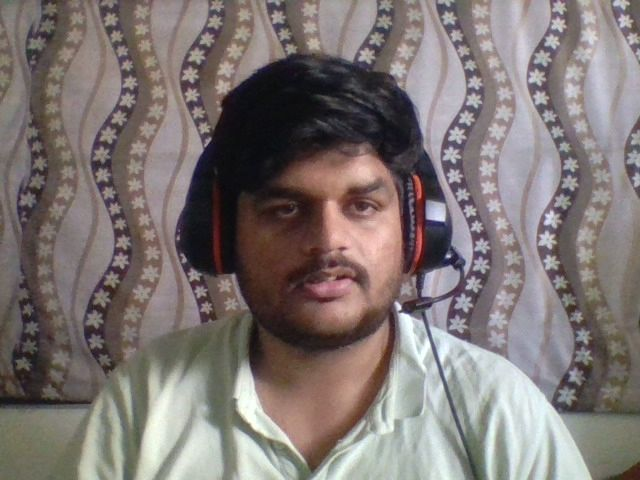

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Loding saved image in Emotion detection model

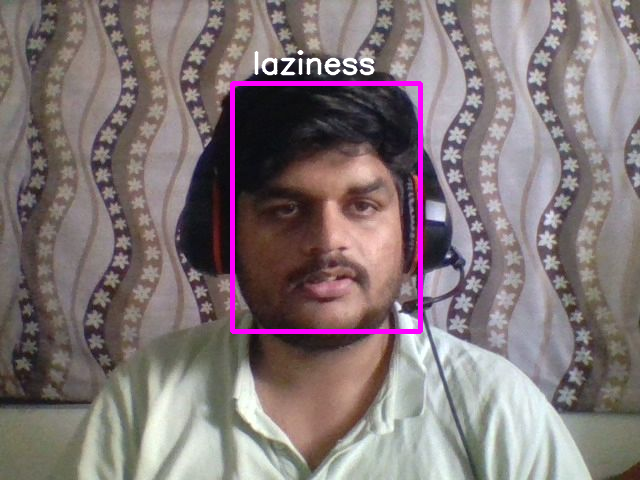

In [ ]:
input = cv2.imread("photo.jpg")
output = emotion_recog(input)
cv2_imshow(output)

Findiag suaitable food for Mood

In [ ]:
find_my_comfort_food('laziness')

3 Popular Comfort Foods in laziness are:
candy
chinese
mcdonalds


Suggesting Restaurants based  on food for mood

In [ ]:
res_data[res_data.Cuisines.str.contains('chinese', case=False)].sort_values(by='Aggregate rating', ascending=False).head(3)

Restaurant ID          Restaurant Name  ...  Rating category pos
9168       18292672               Blue Water  ...                4   4
9171        6506206  18 Degrees Resto Lounge  ...                4   1

[2 rows x 25 columns]